本資料のテーマは、ベルヌーイ試行を中心極限定理を用いて信頼性を解析することを題材にしています。  
有名な題材であるコインの確率分布を歪ませた場合の信頼性区間の変化を確認します。

本資料を作成するにあたり、参考にした図書を紹介します。  
ゼロからはじめるデータサイエンス
https://www.amazon.co.jp/gp/product/4873117860/ref=dbs_a_def_rwt_bibl_vppi_i1

In [1]:
import math
import matplotlib
import random
from matplotlib import pyplot as plt
%matplotlib inline

# 正規分布のPDF/CDF

正規分布の確率密度関数(probability density function; pdf)は
$$f(x|\mu, \sigma)=\frac{1}{\sigma \sqrt{2 \pi} } e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$
で表され、累積分布関数(cumulative distribution function; cdf)は  
$$g(x|\mu, \sigma)=\frac{1}{2} (1 + Erf( \frac{x-\mu}{\sqrt{2}\sigma} ))$$
で得られる。ただし、$Erf(x)$の定義は以下である。
$$Erf(x)=\frac{2}{\sqrt{\pi}}\int^{x}_{0}e^{-t^2}dt$$

それぞれをpythonの関数で表現する。

In [2]:
# probability density function of normal distribution
def normal_pdf(x, mu=0, sigma=1):
    sqrt_two_pi = math.sqrt(2*math.pi)
    return (math.exp(-(x-mu)**2 / 2 / sigma**2)) / sqrt_two_pi / sigma

In [3]:
# cumulative distribution function of normal distribution
def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf( (x-mu) / math.sqrt(2)/sigma )) / 2

関数の出力をグラフにプロットする。

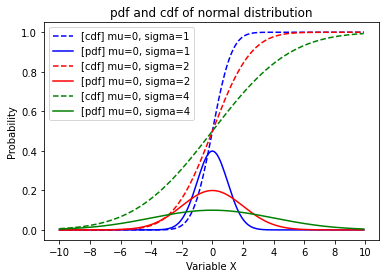

In [4]:
xs = [ x/10.0 for x in range(-100, 100) ]
plt.plot(xs, [normal_cdf(x, sigma=1) for x in xs], '--', label='[cdf] mu=0, sigma=1', color='blue')
plt.plot(xs, [normal_pdf(x, sigma=1) for x in xs], '-', label='[pdf] mu=0, sigma=1', color='blue')

plt.plot(xs, [normal_cdf(x, sigma=2) for x in xs], '--', label='[cdf] mu=0, sigma=2', color='red')
plt.plot(xs, [normal_pdf(x, sigma=2) for x in xs], '-', label='[pdf] mu=0, sigma=2', color='red')

plt.plot(xs, [normal_cdf(x, sigma=4) for x in xs], '--', label='[cdf] mu=0, sigma=4', color='green')
plt.plot(xs, [normal_pdf(x, sigma=4) for x in xs], '-', label='[pdf] mu=0, sigma=4', color='green')


plt.xticks(range(-10,11,2))
plt.legend(loc=2)
plt.xlabel('Variable X')
plt.ylabel('Probability')
plt.title("pdf and cdf of normal distribution")
plt.show()

# 正規分布のCDF逆関数
確率に対応する確率変数$X$を出力するCDF逆関数をpythonで実装する。エラー関数の逆関数を表現することは難しいため、2分探索で求める。

In [5]:
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """binary_search"""
    if mu != 0 or sigma != 1:
        return mu + sigma* inverse_normal_cdf(p, tolerance=tolerance)
    low_z, low_p = -10.0, 0
    hi_z, hi_p   =  10.0, 0
    while hi_z - low_z > tolerance:
        mid_z = (hi_z + low_z) / 2  # 中央の値
        mid_p = normal_cdf(mid_z)
        if mid_p < p:
            low_z = mid_z
        elif mid_p > p:
            hi_z = mid_z
        else:
            break
    return mid_z

確認のため、平均$\mu=0$, 標準偏差$\sigma=1$の正規分布CDFをプロットする。

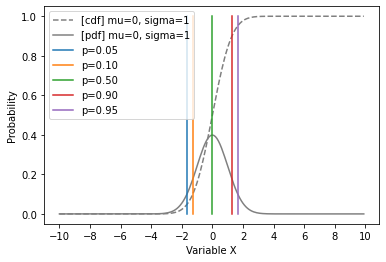

In [6]:
xs = [ x/10.0 for x in range(-100, 100) ]
plt.plot(xs, [normal_cdf(x, sigma=1) for x in xs], '--', label='[cdf] mu=0, sigma=1', color='gray')
plt.plot(xs, [normal_pdf(x, sigma=1) for x in xs], '-', label='[pdf] mu=0, sigma=1', color='gray')

[ plt.plot( [inverse_normal_cdf(p), inverse_normal_cdf(p)], 
            [0,1], 
            '-', label='p={0:.02f}'.format(p) ) 
            for p in [0.05, 0.10, 0.5, 0.9, 0.95]
]
plt.xticks(range(-10,11,2))
plt.legend(loc=2)
plt.xlabel('Variable X')
plt.ylabel('Probability')
plt.show()

# 中心極限定理によるベルヌーイ試行の検定

試行回数=$n$, ベルヌーイ試行の確率=$p$とする。  
ベルヌーイ試行と2項分布の関数を定義する。

In [7]:
# ベルヌーイ試行
def bernouilli_trial(p):
    return 1 if random.random() < p else 0

# 2項分布
def binormal(n, p):
    return sum( bernouilli_traial(p) for _ in range(n) )

ベルヌーイ試行の確率分布 Bernoulli(p)の特徴は以下である。  
 - 平均$\mu$    = $p$
 - 標準偏差$\sigma$ = $\sqrt{p(1-p)}$
 
中心極限定理より、n回だけ試行して事象が発生した回数の分布は
 - 平均$\mu$    = $n p$
 - 標準偏差$\sigma$ = $\sqrt{np(1-p)}$
 で表すことができる。

ベルヌーイ試行のサンプリングを正規分布に近似する関数を定義する。

In [8]:
def normal_approximation_to_binomial(n, p):
    mu = n * p
    sigma = math.sqrt( n * p * (1-p) )
    return mu, sigma

次に、正規分布の累積分布関数を用いて、確率変数と発生確率の関係を算出する関数を実装する。  
累積分布関数$g(x)$が確率変数$X$が$x$以下となる確率を返すことを利用する。

In [9]:
#  X  -->  Probability

# 変数が閾値を下回る確率
normal_probability_below = normal_cdf

# 変数が閾値を上回る確率
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# 変数がhiより小さく、loより大きい確率(範囲内)
def normal_probability_between(lo, hi, mu=0, sigma=1):
    return normal_cdf(lo, mu, sigma) - normal_cdf(hi, mu, sigma)

# 変数がhiより大きく、loより小さい確率(範囲外)
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1.0 - normal_probability_between( lo, hi, mu, sigma )

In [10]:
# Probability --> X range

# maximum X , where p <= Probability
def normal_upper_bound(probability, mu=0, sigma=1):
    return inverse_normal_cdf( probability, mu, sigma )

# manimum X , where p >= Probability
def normal_lower_bound(probability, mu=0, sigma=1):
    return inverse_normal_cdf( 1-probability, mu, sigma )

# 指定された確立を包含する(平均を中心に)対称な境界を返す
def normal_two_sided_bounds(probability, mu=0, sigma=1):
    tail_probability = (1 - probability) / 2
    
    upper_bound = normal_lower_bound( tail_probability, mu, sigma )
    lower_bound = normal_upper_bound( tail_probability, mu, sigma )
    return lower_bound, upper_bound

# コイントスと信頼性区間

## 1) 公平なコイントス(試行回数$n$=1000, 確率$p$=0.5)

In [11]:
mu_0, sigma_0  =normal_approximation_to_binomial( 1000, 0.5 )
mu_0, sigma_0

(500.0, 15.811388300841896)

有意性(5%)の区間をしらべる。

In [12]:
normal_two_sided_bounds( 0.95, mu_0, sigma_0 )

(469.01026640487555, 530.9897335951244)

## 不公平なコイントス(試行回数$n$=1000, 確率$p$=0.55)

In [13]:
mu_1, sigma_1  =normal_approximation_to_binomial( 1000, 0.55 )
mu_1, sigma_1

(550.0, 15.732132722552272)

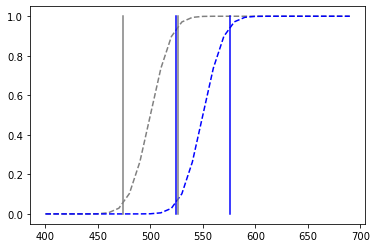

In [14]:
xs = [ x*10 for x in range(40, 70) ]
plt.plot(xs, [normal_cdf(x, mu=mu_0, sigma=sigma_0) for x in xs], '--', label='[cdf] mu={0}, sigma={1}'.format(mu_0, sigma_0), color='gray')
plt.plot(xs, [normal_cdf(x, mu=mu_1, sigma=sigma_1) for x in xs], '--', label='[cdf] mu={0}, sigma={1}'.format(mu_1, sigma_1), color='blue')
#plt.plot(xs, [normal_pdf(x, mu=mu_1, sigma=sigma_1) for x in xs], '-', label='[pdf] mu=0, sigma=1', color='blue')

[ plt.plot( [inverse_normal_cdf(p, mu=mu_0, sigma=sigma_0), inverse_normal_cdf(p, mu=mu_0, sigma=sigma_0)], [0,1], '-', label='p={0:.02f}'.format(p), color='gray' ) for p in [0.05, 0.95]]
[ plt.plot( [inverse_normal_cdf(p, mu=mu_1, sigma=sigma_1), inverse_normal_cdf(p, mu=mu_1, sigma=sigma_1)], [0,1], '-', label='p={0:.02f}'.format(p), color='blue' ) for p in [0.05, 0.95]]
plt.xticks(range(400, 750, 50))
#plt.legend(loc=2)
plt.show()

## 異なるコインでの95%信頼区間の違い

表が出る確率が異なるコインを1000回投げて、表が出る回数の95%信頼性区間は以下である。

In [15]:
print( 'p={:.2f} --> 近似正規分布(mu, sigma)=({}, {:.1f}) --> 95%信頼性区間={:.0f}回～{:.0f}回'.format(
    0.5,  mu_0, sigma_0, inverse_normal_cdf(0.05, mu=mu_0, sigma=sigma_0), inverse_normal_cdf(0.95, mu=mu_0, sigma=sigma_0) ))
print( 'p={:.2f} --> 近似正規分布(mu, sigma)=({}, {:.1f}) --> 95%信頼性区間={:.0f}回～{:.0f}回'.format(
    0.55, mu_1, sigma_1, inverse_normal_cdf(0.05, mu=mu_1, sigma=sigma_1), inverse_normal_cdf(0.95, mu=mu_1, sigma=sigma_1) ))

p=0.50 --> 近似正規分布(mu, sigma)=(500.0, 15.8) --> 95%信頼性区間=474回～526回
p=0.55 --> 近似正規分布(mu, sigma)=(550.0, 15.7) --> 95%信頼性区間=524回～576回


## 参考: 95%信頼区間となる正規分布の範囲

In [20]:
mu, sigma = 0, 1
p1, p2  = (1-0.95)/2.0, 0.95+(1-0.95)/2.0
'{:.2f} - {:.2f}'.format(inverse_normal_cdf(p1, mu=mu, sigma=sigma), 
                      inverse_normal_cdf(p2, mu=mu, sigma=sigma))

'-1.96 - 1.96'

正規分布の$-1.96 \sigma$～$+1.96 \sigma$の範囲が95%信頼区間である。